## Boiler plate

In [35]:
#!pip install xgboost

jupyterlab-launcher 0.13.1 has requirement jsonschema>=2.6.0, but you'll have jsonschema 2.5.1 which is incompatible.
You are using pip version 10.0.0, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [58]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, cohen_kappa_score
import pickle
import xgboost as xgb
%matplotlib inline

class_names = ["A", "B", "None"]

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Prepare the test data

In [60]:
df = pd.read_csv("original_data/cust_actual_merged.csv")
df_copy = pd.read_csv("original_data/cust_actual_merged.csv")
print('Test dataset shape {0}, {1}'.format(df.shape[0], df.shape[1]))

# strip the spaces in the header, if present
df = df.rename(columns=lambda x: x.strip())
df.columns.values

categorical_features = ["sex", "mstatus", "occupation", "education", "children"]
df[categorical_features].head()
df["children"] = df["children"].astype(str)
label_encoders = {}
label_mappings = {}
for categorical_feature in categorical_features:
    label_encoders[categorical_feature] = preprocessing.LabelEncoder()
    df[categorical_feature + "Num"] = label_encoders[categorical_feature].fit_transform(df[categorical_feature])
    label_mappings[categorical_feature] = label_encoders[categorical_feature].classes_

label_encoders = {}
label_mappings = {}
for categorical_feature in categorical_features:
    label_encoders[categorical_feature] = preprocessing.LabelEncoder()
    df[categorical_feature + "Num"] = label_encoders[categorical_feature].fit_transform(df[categorical_feature])
    label_mappings[categorical_feature] = label_encoders[categorical_feature].classes_

for categorical_feature in categorical_features:
    for class_value in label_mappings[categorical_feature]:
        df[categorical_feature + "_" + (class_value)] = df[categorical_feature] == np.array([(class_value)] * df.shape[0])
        df[categorical_feature + "_" + (class_value)] = df[categorical_feature + "_" + (class_value)].astype(int)

# drop the categorical values
df = df.drop(categorical_features, axis=1)

df.head()


train_df = pd.read_csv("working_data/trial_promo_training.csv")
features_to_scale = ["age", "income", "avbal", "avtrans"]
min_max_scaler = preprocessing.MinMaxScaler()

# fit on the train data
train_df[features_to_scale] = min_max_scaler.fit(train_df[features_to_scale])

# transform the test data
df[features_to_scale] = min_max_scaler.transform(df[features_to_scale])
df.head()

customer_ids = df["index"]
df = df.drop("index", axis=1)
df.head()

df.columns

Test dataset shape 4000, 12


Index(['age', 'income', 'avbal', 'avtrans', 'status', 'score', 'sexNum',
       'mstatusNum', 'occupationNum', 'educationNum', 'childrenNum', 'sex_F',
       'sex_M', 'mstatus_divorced', 'mstatus_married', 'mstatus_single',
       'mstatus_widowed', 'occupation_IT', 'occupation_construct',
       'occupation_education', 'occupation_finance', 'occupation_government',
       'occupation_legal', 'occupation_manuf', 'occupation_medicine',
       'occupation_retired', 'education_postgrad', 'education_professional',
       'education_secondary', 'education_tertiary', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4'],
      dtype='object')

In [61]:
df = df.loc[:,df.columns != "score"]
y_test_labels = df["status"]
y_test = df["status"].replace("A", 0).replace("B", 1).replace("None", 2)
df = df.loc[:,df.columns != "status"]

In [62]:
df.columns

Index(['age', 'income', 'avbal', 'avtrans', 'sexNum', 'mstatusNum',
       'occupationNum', 'educationNum', 'childrenNum', 'sex_F', 'sex_M',
       'mstatus_divorced', 'mstatus_married', 'mstatus_single',
       'mstatus_widowed', 'occupation_IT', 'occupation_construct',
       'occupation_education', 'occupation_finance', 'occupation_government',
       'occupation_legal', 'occupation_manuf', 'occupation_medicine',
       'occupation_retired', 'education_postgrad', 'education_professional',
       'education_secondary', 'education_tertiary', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4'],
      dtype='object')

### Load the different models

## Neural network

In [63]:
from keras.models import load_model

# the model must be in the models folder
model_to_use = "model-004-0.82.h5"
model = load_model('models/'+model_to_use)

In [64]:
num_columns = ["sexNum", "mstatusNum", "occupationNum", "educationNum", "childrenNum"]
X_test = df.drop(num_columns, axis=1)
y_test_pred_nn = model.predict(X_test)
print("Num predictions: {0}".format(len(y_test_pred_nn)))
y_test_pred_nn = np.argmax(y_test_pred_nn, axis=1)

Num predictions: 4000


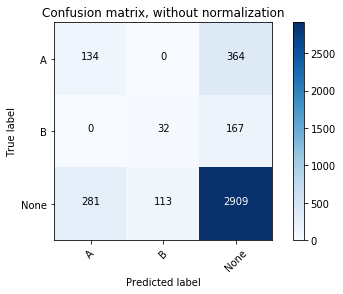

In [65]:
cm_nn = confusion_matrix(y_test, y_test_pred_nn)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_nn, classes=class_names,
                      title='Confusion matrix, without normalization')

In [66]:
print("test accuracy:", accuracy_score(y_test, y_test_pred_nn))

test accuracy: 0.76875


## Xgboost

test accuracy: 0.799


G:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


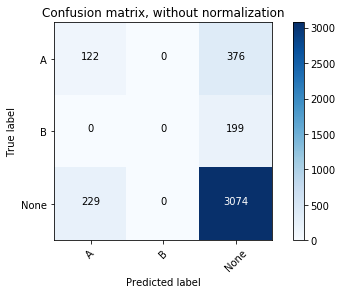

In [67]:
feature_columns = ["age", "income", "avbal", "avtrans", "sexNum", "mstatusNum", "occupationNum", "educationNum", "childrenNum"]
X_test = df.loc[:, feature_columns]
xg_boost_model = pickle.load(open("models/xgboost_kappa_0_2576.pickle.dat", "rb"))
y_test_pred_xg_boost = xg_boost_model.predict(X_test)

print("test accuracy:", accuracy_score(y_test_labels, y_test_pred_xg_boost))

cm_xgboost = confusion_matrix(y_test_labels, y_test_pred_xg_boost)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_xgboost, classes=class_names, title='Confusion matrix, without normalization')

## AdaBoost

## Ensemble different classification models

In [68]:
from collections import Counter

# predictions inside the list to be sorted in decreasing order of performance
def get_max_voted_predictions(list_of_predictions):
    if len(list_of_predictions) >= 3:
        final_predictions = []
        num_models = len(list_of_predictions)
        
        # y_test = df["status"].replace("A", 0).replace("B", 1).replace("None", 2)
        
        for itr in range(num_models):
            list_of_predictions[i] = list_of_predictions[i].replace("A", 0).replace("B", 1).replace("None", 2)
            
        for itr in range(list_of_predictions[0]):
            # get the default prediction from the first model
            default_prediction = list_of_predictions[0][itr]
            
            c = Counter(list_of_predictions[:][itr])
            most_common_tuples = c.most_common(1)
            most_common_count = most_common_tuples[0][1]
            if most_common_count > (num_models // 2):
                final_predictions.append(most_common_tuples[0][0])
            else:
                final_predictions.append(default_prediction)
                
        return final_predictions
                